In [1]:
import numpy as np
import math
from deap import base, creator, tools
import random
import pandas as pd
import matplotlib.pyplot as plt
class setupDEAP():
   pass

#!GA parameters json
CXPB, MUTPB, NGEN, POP_SIZE = 0.9, 0.05, 100, 100
IND_SIZE = 10 #number of decision variables

#fitness function
def evaluate(individual):
    rastrigin = 10 * IND_SIZE
    for i in range(IND_SIZE):
      rastrigin += (individual[i]*individual[i] - 10 * (math.cos(2*np.pi*individual[i])))
    return rastrigin,

creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)
toolbox = base.Toolbox()
toolbox.register("attribute", random.random)
toolbox.register("individual", tools.initRepeat, creator.Individual,toolbox.attribute, n=IND_SIZE)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=1, indpb=0.1)
toolbox.register("select", tools.selTournament, tournsize=3)
toolbox.register("evaluate", evaluate)




In [2]:

class evolutionRCE():
   pass

ind_array = []        

def main():
    #store statistics of all generations
    stats = tools.Statistics(key=lambda ind: ind.fitness.values)
    stats.register("avg", np.mean)
    stats.register("std", np.std)
    stats.register("min", np.min)
    stats.register("max", np.max)
    logbook = tools.Logbook()

    #GA initial population
    pop = toolbox.population(n=POP_SIZE)

    #store best individual
    hof = tools.HallOfFame(1)
    hof.update(pop)

    # Evaluate the entire population
    fitnesses = map(toolbox.evaluate, pop)
    for ind, fit in zip(pop, fitnesses):
        ind.fitness.values = fit

    #generational loop until stop criteria
    for g in range(NGEN):
        # Select the next generation individuals
        offspring = toolbox.select(pop, k=len(pop))
        # Clone the selected individuals
        offspring = [toolbox.clone(ind) for ind in offspring]

        # Apply crossover and mutation on the offspring
        for child1, child2 in zip(offspring[::2], offspring[1::2]):
            if random.random() < CXPB:
                toolbox.mate(child1, child2)
                del child1.fitness.values
                del child2.fitness.values

        for mutant in offspring:
            if random.random() < MUTPB:
                toolbox.mutate(mutant)
                del mutant.fitness.values

        # Evaluate the individuals with an invalid fitness
        invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
        fitnesses = map(toolbox.evaluate, invalid_ind)
        for ind, fit in zip(invalid_ind, fitnesses):
            ind.fitness.values = fit

        # The population is entirely replaced by the offspring
        pop[:] = offspring

        #Elitism
        hof.update(pop)
        #update pop with best
        pop[0] = toolbox.clone(hof[0])

        data_generation ={
            "Generation": g+1,
            "Variaveis de Decisão":hof,
            "Ind Valido":hof[0].fitness.valid,
            "Fitness":hof[0].fitness
        }
        ind_array.append(data_generation)

        #save each generation record in the logbook
        record = stats.compile(pop)
        logbook.record(gen=g, **record)

    df_results = pd.DataFrame(ind_array)
    display(df_results)
    return pop,logbook,hof[0]

,Generation,Variaveis de Decisão,Ind Valido,Fitness
0,1,"([-0.9828946935854269, -0.014664482881632933, ...",True,"(22.10711685367798,)"
1,2,"([-0.9828946935854269, -0.014664482881632933, ...",True,"(18.35474235094553,)"
2,3,"([-0.9828946935854269, -0.014664482881632933, ...",True,"(12.421874042056496,)"
3,4,"([-0.9828946935854269, -0.014664482881632933, ...",True,"(12.421874042056496,)"
4,5,"([-0.9828946935854269, -0.014664482881632933, ...",True,"(11.577122488818114,)"
...,...,...,...,...
95,96,"([-0.9828946935854269, -0.014664482881632933, ...",True,"(3.453605654594984,)"
96,97,"([-0.9828946935854269, -0.014664482881632933, ...",True,"(3.453605654594984,)"
97,98,"([-0.9828946935854269, -0.014664482881632933, ...",True,"(3.453605654594984,)"
98,99,"([-0.9828946935854269, -0.014664482881632933, ...",True,"(3.453605654594984,)"


best solution variables 
 [-0.9828946935854269, -0.014664482881632933, -0.016293919429870726, 0.9695640785569652, 0.05666174122720413, 0.03444282020982148, -0.04009203440136075, 0.008966612633122595, 0.008466543695293652, -0.0007419140660298862]
best solution fitness 
 (3.453605654594984,)


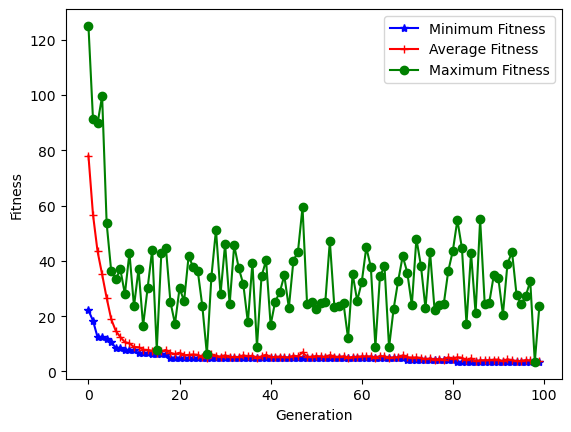

In [3]:


#call the EA
pop,logbook,best = main()

#read the logbook
gen = logbook.select("gen")
fit_avg = logbook.select("avg")
fit_std = logbook.select("std")
fit_min = logbook.select("min")
fit_max = logbook.select("max")

#print best individual
print("best solution variables \n", best)
#print best fitness
print("best solution fitness \n",[best.fitness][0])

#plot
fig, ax1 = plt.subplots()
line1 = ax1.plot(gen, fit_min, "*b-", label="Minimum Fitness")
line2 = ax1.plot(gen, fit_avg, "+r-", label="Average Fitness")
line3 = ax1.plot(gen, fit_max, "og-", label="Maximum Fitness")
ax1.set_xlabel("Generation")
ax1.set_ylabel("Fitness")
lns = line1 + line2 + line3
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc="upper right")
plt.show()